In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:
##This is adapted from https://github.com/tkipf/gae/blob/master/gae/train.py and https://github.com/tkipf/pygcn/blob/master/pygcn/train.py##

import time
import os

# Train on CPU (hide GPU) due to memory constraints
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import image.loadImage as loadImage
import gae.gae.optimizer as optimizer
import image.modelsCNN as modelsCNN

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [3]:
# Settings
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
use_cuda=True
fastmode=False #Validate during training pass
seed=3
epochs=500
saveFreq=10
lr=0.00001 #initial learning rate
lr_adv=0.001
weight_decay=0 #Weight for L2 loss on embedding matrix.

batchsize=16

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
# randFeatureSubset=None
model_str='alexnet'

kernel_size=4
stride=2
padding=1

hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=512
hidden5=512
fc_dim1=512*25*25
fc_dim2=1024

pretrainedAE=None #{'name':'controlphy5XAbin_01_dca','epoch':9990}
# training_samples=['control13','disease13','disease8','control8']
training_samples=['disease13','control13']
targetBatch=None
switchFreq=1
diamThresh_mul=800
minThresh_mul=12
overlap=int(diamThresh_mul*0.7)
areaThresh=diamThresh_mul*diamThresh_mul*0.7
name='cd13_thresh25min12_overlap70area70_04_shuffled'
logsavepath='/mnt/external_ssd/xinyi/log/train_cnnClf_starmap/'+name
modelsavepath='/mnt/external_ssd/xinyi/models/train_cnnClf_starmap/'+name
plotsavepath='/mnt/external_ssd/xinyi/plots/train_cnnClf_starmap/'+name

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
datadir='/home/xinyiz/2021-01-13-mAD-test-dataset'

# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True

# Load data
# if randFeatureSubset != None:
#     idx=np.random.choice(features.shape[1],randFeatureSubset,replace=False)
#     features=features[:,idx]


In [4]:
plaqueCentroids={}
plaqueCentroids['disease13']=pd.read_csv('/home/xinyiz/2021-01-13-mAD-test-dataset/AD_mouse9494/trimmed_images/PlaqueMask3.csv', header=0)
plaqueCentroids['disease8']=pd.read_csv('/home/xinyiz/2021-01-13-mAD-test-dataset/AD_mouse9723/trimmed_images/PlaqueMask3.csv', header=0)
maxArea=max(np.max(plaqueCentroids['disease13']['Area']),np.max(plaqueCentroids['disease8']['Area']))
plaqueCutoffRadius=max(int(np.sqrt(maxArea)/2),int(diamThresh_mul/2))

In [5]:
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [6]:
s=training_samples[0]
trainInputnp, valInputnp, _,trainLabelsnp,valLabelsnp,_,_,_,_=loadImage.loadandsplitPlaque_overlap(areaThresh,plaqueCentroids[s][['Y','X']].to_numpy().astype(int),plaqueCutoffRadius,sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,returnPos=True)

#all_thresh25min12_overlap70area70_04_shuffled only
trainInputnp=trainInputnp.astype('float32')
valInputnp=valInputnp.astype('float32')
for sidx in range(1,len(training_samples)):
    s=training_samples[sidx]
    if 'disease' in s:
        inputlist=loadImage.loadandsplitPlaque_overlap(areaThresh,plaqueCentroids[s][['Y','X']].to_numpy().astype(int),plaqueCutoffRadius,sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,returnPos=True)
    if 'control' in s:
        inputlist=loadImage.loadandsplit(sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,clf=True,returnPos=True)
    trainInputnp=np.concatenate((trainInputnp,inputlist[0].astype('float32')),axis=0)
    valInputnp=np.concatenate((valInputnp,inputlist[1].astype('float32')),axis=0)
    trainLabelsnp=np.concatenate((trainLabelsnp,inputlist[3]),axis=0)
    valLabelsnp=np.concatenate((valLabelsnp,inputlist[4]),axis=0)
inputlist=None

sampleIdx=np.arange(trainInputnp.shape[0])
np.random.shuffle(sampleIdx)


(22210, 22344)
plaque965
no plaque3648
(22294, 19552)
plaque397
no plaque4563
(22355, 18953)
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells


In [7]:
s

'control13'

In [6]:
npos=0
nneg=0
npos=np.sum(trainLabelsnp)
nneg=trainLabelsnp.shape[0]-npos
print(npos)
print(nneg)

NameError: name 'trainLabelsnp' is not defined

In [5]:
mse=torch.nn.MSELoss()
# mse=torch.nn.MSELoss(reduction=None)
# Create model
if model_str=='alexnet':
    model = modelsCNN.AlexNet(2)
#     lossCE=torch.nn.CrossEntropyLoss()
    lossCE=torch.nn.CrossEntropyLoss(torch.tensor([(nneg+npos)/nneg,(nneg+npos)/npos]).cuda().float())

# if model_str=='cnnvae_clf':
#     model = modelsCNN.CNN_VAE_clf(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
#     lossCE=torch.nn.CrossEntropyLoss(torch.tensor([1,imageslist['disease13'][3].shape[0]/np.sum(imageslist['disease13'][3])]).cuda().float())

if use_cuda:
    model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


In [10]:
# model.load_state_dict(torch.load(os.path.join(modelsavepath,str(9360)+'.pt')))
# epochs=20000
if pretrainedAE:
    print('loading '+pretrainedAE['name']+' epoch '+str(pretrainedAE['epoch']))
    model.load_state_dict(torch.load(os.path.join('/mnt/xinyi/pamrats/models/train_gae_starmap/'+pretrainedAE['name'],str(pretrainedAE['epoch'])+'.pt')))
    
def train(epoch):
    t = time.time()
    model.train()
    
    loss_all=0
    for i in range(int(np.ceil(trainInputnp.shape[0]/batchsize))):
        trainIdx=sampleIdx[i*batchsize:min((i+1)*batchsize,trainInputnp.shape[0])]
        
        trainInput=trainInputnp[trainIdx]
        labels=trainLabelsnp[trainIdx]
        if use_cuda:
            trainInput=torch.tensor(trainInput).cuda().float()
            labels=torch.tensor(labels).cuda().long()
        optimizer.zero_grad()

        pred = model(trainInput)


        loss=lossCE(pred,labels)
        loss_all+=loss.item()
        
        loss.backward()
        optimizer.step()

    loss_all=loss_all/trainInputnp.shape[0]
    
    model.eval()
    loss_val_all=0
    for i in range(int(np.ceil(valInputnp.shape[0]/batchsize))):
        valInput=valInputnp[i*batchsize:min((i+1)*batchsize,valInputnp.shape[0])]
        labels=valLabelsnp[i*batchsize:min((i+1)*batchsize,valInputnp.shape[0])]
        if use_cuda:
            valInput=torch.tensor(valInput).cuda().float()
            labels=torch.tensor(labels).cuda().long()
        pred = model(valInput)

        loss_val_all+=lossCE(pred,labels).item()

    loss_val_all=loss_val_all/valInputnp.shape[0]
    
    print('Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_val: {:.4f}'.format(loss_val_all))
    return loss_all,loss_val_all
    
train_loss_ep=[None]*epochs
val_loss_ep=[None]*epochs
t_ep=time.time()

for ep in range(epochs):
# for ep in range(10000,20000):
    
    train_loss_ep[ep],val_loss_ep[ep]=train(ep)

        
    if ep%saveFreq == 0:
        torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        model.cuda()
        torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


Epoch: 0000 loss_train: 0.0423 loss_val: 0.0375
Epoch: 0001 loss_train: 0.0398 loss_val: 0.0341
Epoch: 0002 loss_train: 0.0363 loss_val: 0.0319
Epoch: 0003 loss_train: 0.0353 loss_val: 0.0305
Epoch: 0004 loss_train: 0.0346 loss_val: 0.0300
Epoch: 0005 loss_train: 0.0344 loss_val: 0.0291
Epoch: 0006 loss_train: 0.0338 loss_val: 0.0289
Epoch: 0007 loss_train: 0.0336 loss_val: 0.0288
Epoch: 0008 loss_train: 0.0332 loss_val: 0.0286
Epoch: 0009 loss_train: 0.0331 loss_val: 0.0283
Epoch: 0010 loss_train: 0.0330 loss_val: 0.0285
Epoch: 0011 loss_train: 0.0326 loss_val: 0.0283
Epoch: 0012 loss_train: 0.0325 loss_val: 0.0282
Epoch: 0013 loss_train: 0.0324 loss_val: 0.0279
Epoch: 0014 loss_train: 0.0320 loss_val: 0.0284
Epoch: 0015 loss_train: 0.0318 loss_val: 0.0279
Epoch: 0016 loss_train: 0.0317 loss_val: 0.0280
Epoch: 0017 loss_train: 0.0315 loss_val: 0.0279
Epoch: 0018 loss_train: 0.0313 loss_val: 0.0278
Epoch: 0019 loss_train: 0.0311 loss_val: 0.0279
Epoch: 0020 loss_train: 0.0308 loss_val:

KeyboardInterrupt: 

In [11]:
trainInputnp, valInputnp,trainLabelsnp,valLabelsnp,_=None,None,None,None,None
    
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)


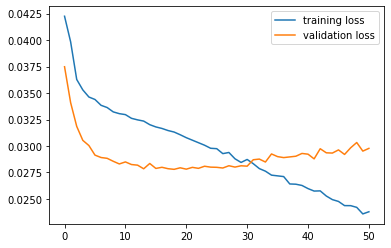

In [12]:
plt.plot(np.arange(epochs),train_loss_ep)
plt.plot(np.arange(epochs),val_loss_ep)
# plt.ylim((0,0.01))
# plt.xlim((0,150))
plt.legend(['training loss','validation loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3.jpg'))
plt.show()


In [13]:
# name='c13k20XA_07_dca'
# logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as output:
#     val_loss_a_ep=pickle.load(output)
np.argmin(val_loss_ep[:40])
# np.where(np.logical_not(np.isfinite(val_loss_ep[:])))
# val_loss_a_ep[8700]

18

In [7]:
imageslist={}
# for s in ['disease13','disease8']:
#     imageslist[s]=loadImage.loadandsplitPlaque_overlap(areaThresh,plaqueCentroids[s][['Y','X']].to_numpy().astype(int),plaqueCutoffRadius,sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,returnPos=True)
    
# for s in ['control13','control8']:
for s in ['control13']:
    imageslist[s]=loadImage.loadandsplit(sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,clf=True,returnPos=True)
    

(22355, 18953)
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells


In [8]:
def plotExprs(exprs,exprs2,savename,embedding,embedding2,savepath,savenameAdd=''):
#     fig, ax = plt.subplots(dpi=400)
    if not exprs is None:
        plt.scatter(embedding[:,0],embedding[:,1],s=5,c=exprs,cmap='Greys',edgecolors='blue',linewidth=0.2,alpha=1,marker='o',vmin=0,vmax=4)
    if not exprs2 is None:
        plt.scatter(embedding2[:,0],embedding2[:,1],s=5,c=exprs2,cmap='Greys',edgecolors='green',linewidth=0.2,alpha=1,marker='^',vmin=0,vmax=4)
    plt.colorbar(orientation='vertical', shrink = 0.5)
    plt.gca().set_aspect('equal', 'datalim')
#     fig.set_figheight(5)
#     fig.set_figwidth(5)
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.jpg'),dpi=400)
#     plt.show()
    
#     fig.clf()
    plt.close('all')

In [10]:
def plotLoss(inputNp,labelsNp,coordNp,name,savenameAdd=''):
    loss_test_all=np.zeros(inputNp.shape[0])
    for i in range(inputNp.shape[0]):
        testInput=inputNp[[i]]
        labels=labelsNp[[i]]
        if use_cuda:
            testInput=torch.tensor(testInput).cuda().float()
            labels=torch.tensor(labels).cuda().long()
        pred = model(testInput)
        loss_test_all[i]=lossCE(pred,labels).item()
    
    posidx=labelsNp==1
    negidx=labelsNp==0
    loss_test_posLoss=np.sum(loss_test_all[posidx])/np.sum(posidx)
    loss_test_negLoss=np.sum(loss_test_all[negidx])/np.sum(negidx)
    print(name+' results',
          'loss positive: {:.4f}'.format(loss_test_posLoss),
         'loss negative: {:.4f}'.format(loss_test_negLoss))
    
    plotExprs(loss_test_all[posidx],loss_test_all[negidx],name+'loss'+s,coordNp[posidx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd)
    plotExprs(loss_test_all[posidx],None,name+'loss'+s+'_positive',coordNp[posidx],None,plotsavepath,savenameAdd=savenameAdd)
    plotExprs(None,loss_test_all[negidx],name+'loss'+s+'_negative',None,coordNp[negidx],plotsavepath,savenameAdd=savenameAdd)


testepoch=22
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
model.eval()
plotepoch='epoch22'
for s in sampleidx.keys():
    if s!='control13':
        continue
    print(s)
    trainInputnp, valInputnp, testInputnp, trainLabelsnp,valLabelsnp,testLabelsnp,trainCoordnp,valCoordnp,testCoordnp=imageslist[s]
    plotLoss(testInputnp,testLabelsnp,testCoordnp,'test',plotepoch)
    plotLoss(trainInputnp,trainLabelsnp,trainCoordnp,'train',plotepoch)
    plotLoss(valInputnp,valLabelsnp,valCoordnp,'val',plotepoch)
    plotLoss(np.concatenate((trainInputnp,valInputnp,testInputnp),axis=0),np.concatenate((trainLabelsnp,valLabelsnp,testLabelsnp)),np.concatenate((trainCoordnp,valCoordnp,testCoordnp),axis=0),'all',plotepoch)
    

control13


<ipython-input-10-62066a149cec>:14: RuntimeWarning: invalid value encountered in double_scalars
  loss_test_posLoss=np.sum(loss_test_all[posidx])/np.sum(posidx)


test results loss positive: nan loss negative: 0.1598
train results loss positive: nan loss negative: 0.1607
val results loss positive: nan loss negative: 0.1628
all results loss positive: nan loss negative: 0.1607


In [11]:
pred.shape

torch.Size([1, 2])

In [15]:
labels=testLabelsnp[i]

In [16]:
labels

1

In [ ]:
torch.sum(result[zeroidx])

In [ ]:
# model.pi.weight[:8,:8]
model_str